Episode: 1, Total Timesteps: 46, Episode Reward: -145
Total reward obtained for episode 1: -145
Episode: 2, Total Timesteps: 58, Episode Reward: -111
Total reward obtained for episode 2: -111
Episode: 3, Total Timesteps: 80, Episode Reward: -121
Total reward obtained for episode 3: -121
Episode: 4, Total Timesteps: 93, Episode Reward: -112
Total reward obtained for episode 4: -112
Episode: 5, Total Timesteps: 99, Episode Reward: -105
Total reward obtained for episode 5: -105


/home/ardie85/PHD/Research/code/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 6, Total Timesteps: 107, Episode Reward: -107
Total reward obtained for episode 6: -107
Episode: 7, Total Timesteps: 111, Episode Reward: -103
Total reward obtained for episode 7: -103
Episode: 8, Total Timesteps: 121, Episode Reward: -109
Total reward obtained for episode 8: -109
Episode: 9, Total Timesteps: 137, Episode Reward: -115
Total reward obtained for episode 9: -115
Episode: 10, Total Timesteps: 140, Episode Reward: -102
Total reward obtained for episode 10: -102
Episode: 11, Total Timesteps: 143, Episode Reward: -102
Total reward obtained for episode 11: -102
Episode: 12, Total Timesteps: 149, Episode Reward: -105
Total reward obtained for episode 12: -105
Episode: 13, Total Timesteps: 162, Episode Reward: -112
Total reward obtained for episode 13: -112
Episode: 14, Total Timesteps: 174, Episode Reward: -111
Total reward obtained for episode 14: -111
Episode: 15, Total Timesteps: 207, Episode Reward: -132
Total reward obtained for episode 15: -132
Episode: 16, Total

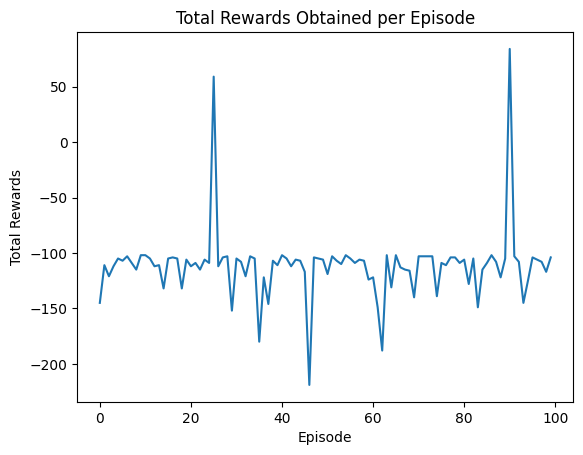

Success rate of episodes: 0.02


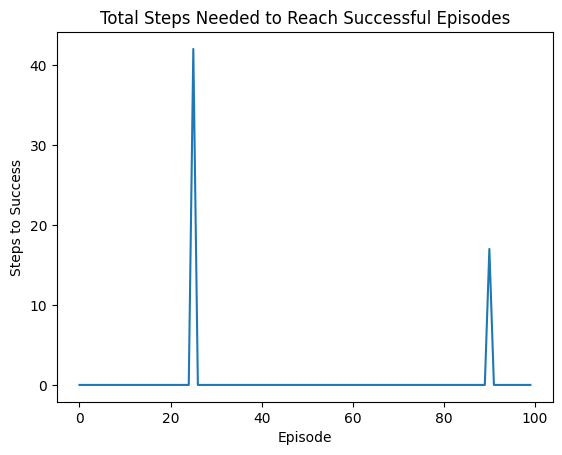

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from environment_static import Env

# Set random seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Actor-critic network architecture
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.actor = nn.Linear(64, action_dim)
        self.critic = nn.Linear(64, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        logits = self.actor(x)
        value = self.critic(x)
        return logits, value

# Proximal Policy Optimization (PPO) algorithm
class PPO:
    def __init__(self, state_dim, action_dim):
        self.policy = ActorCritic(state_dim, action_dim)
        self.learning_rate = 0.0005
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.learning_rate)
        self.gamma = 0.99
        self.eps_clip = 0.2
        self.update_timestep = 20

    def choose_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        logits, _ = self.policy(state)
        action_probs = torch.softmax(logits, dim=-1)
        action = torch.multinomial(action_probs, 1)
        return action.item()

    def calculate_advantages(self, rewards, dones, values, next_value):
        advantages = []
        discounted_sum = 0
        for i in range(len(rewards) - 1, -1, -1):
            discounted_sum = rewards[i] + self.gamma * discounted_sum * (1 - dones[i])
            advantage = discounted_sum - values[i].item()
            advantages.insert(0, advantage)
        return advantages

    def update_policy(self, states, actions, advantages, returns):
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        advantages = torch.FloatTensor(advantages).unsqueeze(1)
        returns = torch.FloatTensor(returns)

        unique_actions, unique_indices = torch.unique(actions, return_inverse=True)

        logits, values = self.policy(states)
        values = values.squeeze()

        action_probs = torch.softmax(logits, dim=-1)
        action_masks = torch.zeros_like(action_probs).scatter_(1, unique_actions.unsqueeze(1), 1)
        old_action_probs = torch.sum(action_probs * action_masks[unique_indices.unsqueeze(1)], dim=1)
        ratios = torch.exp(torch.log(old_action_probs + 1e-10) - torch.log(action_probs + 1e-10))

        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
        actor_loss = -torch.min(surr1, surr2).mean()

        critic_loss = nn.MSELoss()(returns, values)

        loss = actor_loss + 0.5 * critic_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, env, num_episodes):
        total_timesteps = 0
        episode_rewards = []
        success_count = 0
        success_steps = []

        for episode in range(num_episodes):
            total_rewards = 0
            episode_steps = 0
            max_steps = 1000

            states, actions, rewards, dones, next_states = [], [], [], [], []
            episode_reward = 0
            state = env.reset()

            while episode_steps < max_steps:
                action = self.choose_action(state)
                next_state, reward, done = env.step(action)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                dones.append(done)
                next_states.append(next_state)

                episode_reward += reward
                state = next_state
                episode_steps += 1

                total_timesteps += 1

                if done:
                    total_rewards += episode_reward
                    if episode_reward >= 0:  # Considered successful if the total reward is 200 or more
                        success_count += 1
                        success_steps.append(episode_steps)
                    else:
                        success_steps.append(0)
                    break

                if total_timesteps % self.update_timestep == 0:
                    _, next_value = self.policy(torch.FloatTensor(next_states))
                    returns = []
                    discounted_sum = 0
                    for i in range(len(rewards) - 1, -1, -1):
                        discounted_sum = rewards[i] + self.gamma * discounted_sum * (1 - dones[i])
                        returns.insert(0, discounted_sum)

                    advantages = self.calculate_advantages(rewards, dones, torch.cat((self.policy(torch.FloatTensor(states))[1], next_value.detach()), 0), next_value)
                    self.update_policy(states, actions, advantages, returns)

            episode_rewards.append(total_rewards)
            print(f"Episode: {episode + 1}, Total Timesteps: {total_timesteps}, Episode Reward: {episode_reward}")

            # Print total reward obtained for each episode
            print(f"Total reward obtained for episode {episode + 1}: {total_rewards}")

        return episode_rewards, success_count, success_steps

class Analyzer:
    @staticmethod
    def plot_total_rewards(episode_rewards):
        plt.plot(episode_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Rewards')
        plt.title('Total Rewards Obtained per Episode')
        plt.show()

    @staticmethod
    def calculate_success_rate(success_count, n_episodes):
        return success_count / n_episodes

    @staticmethod
    def plot_steps_to_success(success_steps):
        plt.plot(success_steps)
        plt.xlabel('Episode')
        plt.ylabel('Steps to Success')
        plt.title('Total Steps Needed to Reach Successful Episodes')
        plt.show()

if __name__ == "__main__":
    env = Env()
    state_dim = len(env.reset())
    action_dim = len(env.action_space)

    # Initialize PPO agent
    ppo_agent = PPO(state_dim, action_dim)

    # Train PPO agent
    episode_rewards, success_count, success_steps = ppo_agent.train(env, num_episodes=100)

    # Plot total rewards obtained per episode
    Analyzer.plot_total_rewards(episode_rewards)

    # Calculate and print success rate of episodes
    success_rate = Analyzer.calculate_success_rate(success_count, 100)
    print("Success rate of episodes:", success_rate)

    # Plot total steps needed to reach successful episodes
    if success_count > 0:
        Analyzer.plot_steps_to_success(success_steps)
    else:
        print("No successful episodes.")
